# Data Preprocessing

## Data Exploration

Data available from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


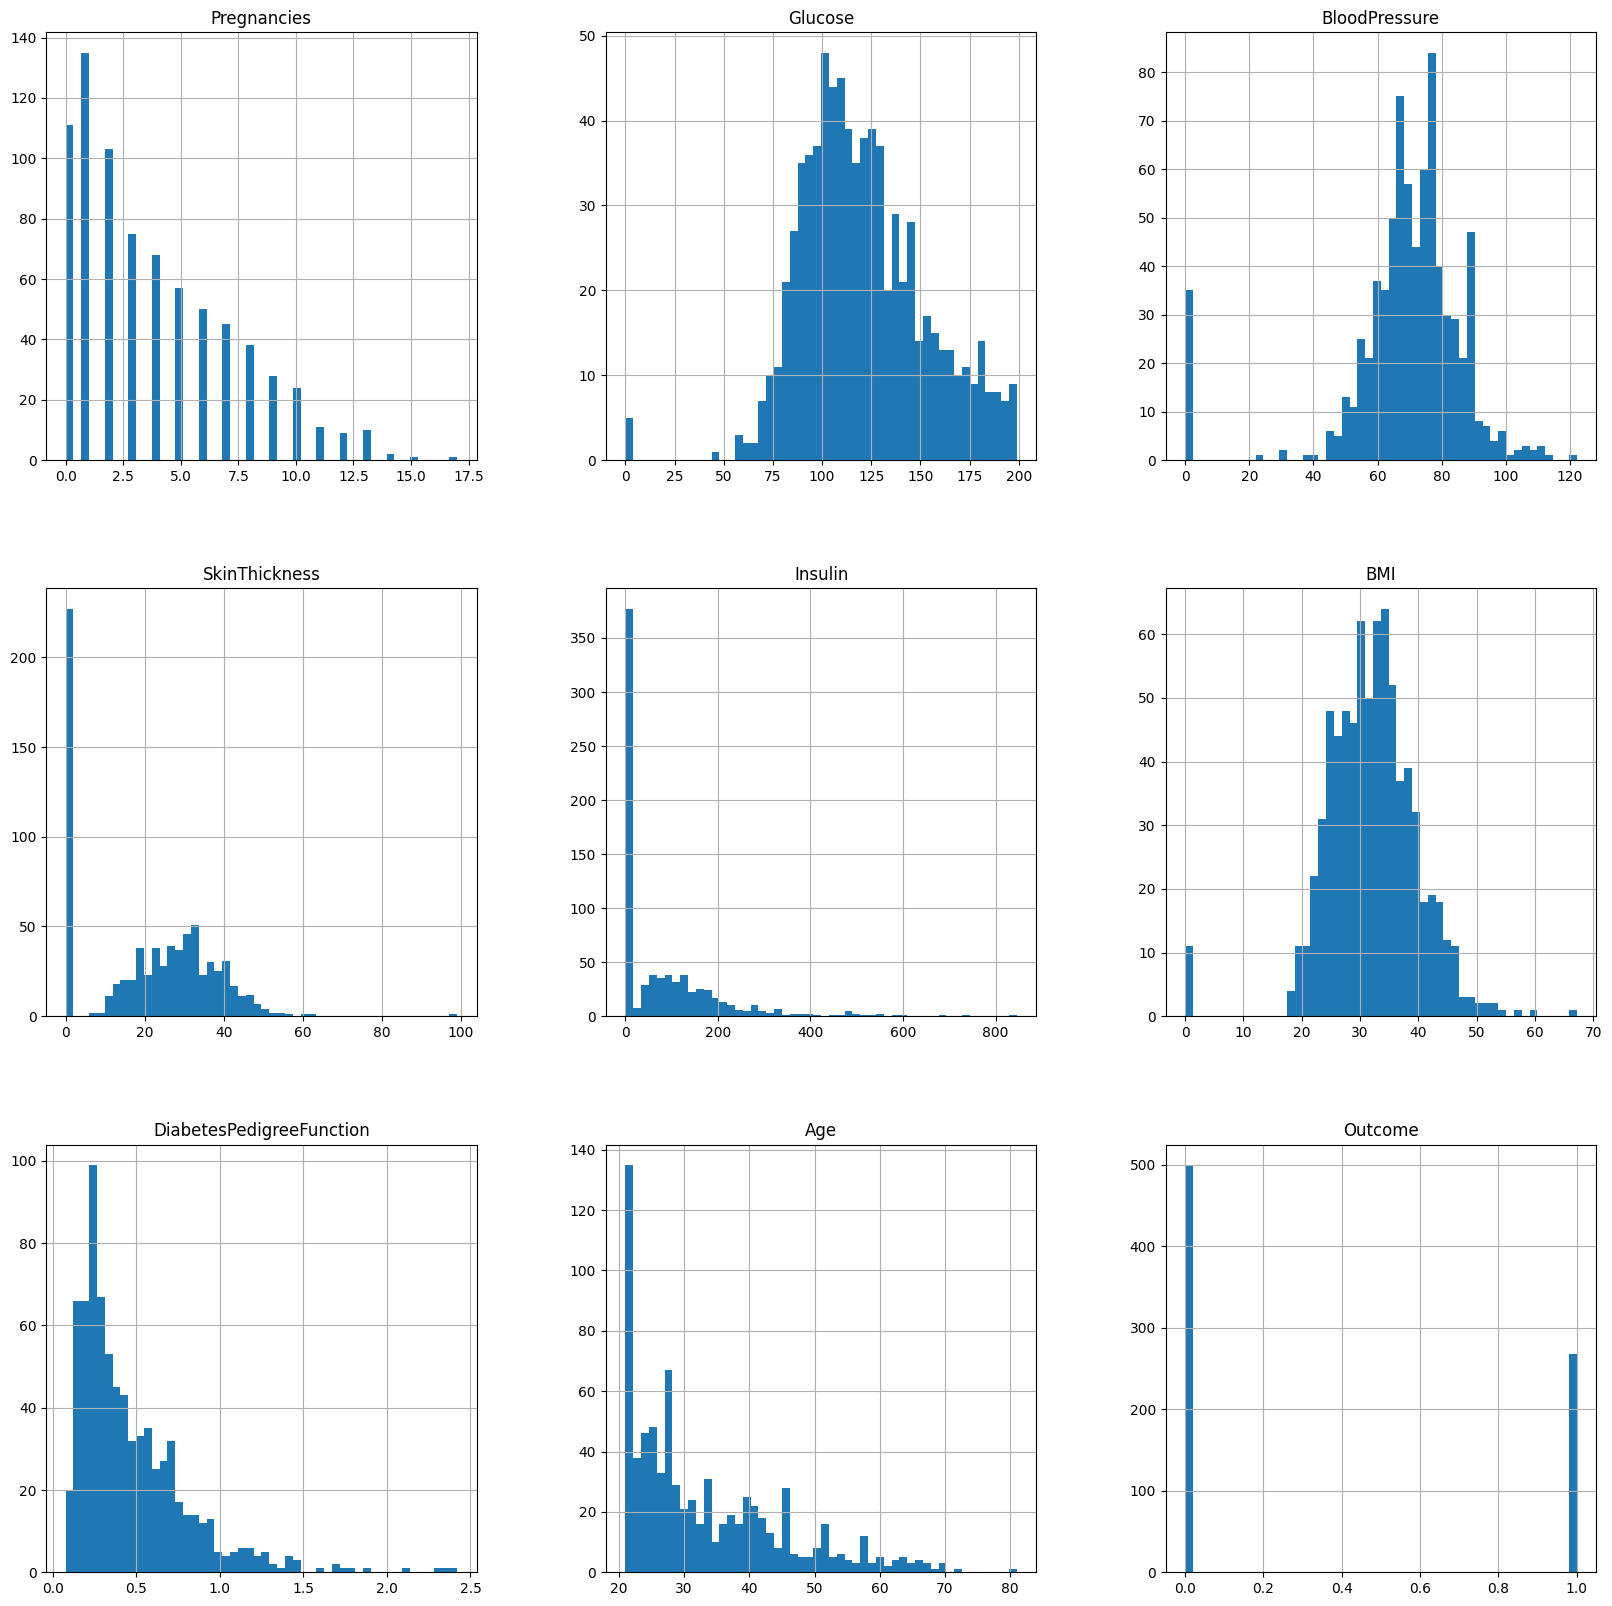

In [1]:
import pandas as pd
from IPython.display import display

CSV_PATH = "diabetes.csv"

df = pd.read_csv(CSV_PATH)

# Display statistics about the dataset
display(df.describe())

# Display histogram of the dataset
df.hist(figsize=(20, 20), bins=50);


## Data Cleaning

Following columns have invalid zero value: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.\
These will be treated as missing value and be replaced with mean.

In [2]:
invalid_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in invalid_cols:
    mean = df[col].mean()
    df[col].replace(0, mean, inplace=True)


## Data Splitting and Standardization

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Extract X (features) and y (target)
X_cols, y_col = df.columns[:8], df.columns[-1]
X = df[X_cols].to_numpy()
y = df[y_col].to_numpy()

# Split training set for cross validation and holdout set for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Standardize features using training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training set into 5 folds for cross validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


# Logistic Regression

## Training with Cross Validation

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Hyperparameters
param_grid = {'C': [0.01, 0.1, 1, 10, 100], "solver": ["newton-cg", "lbfgs", "liblinear"]}

# Create LogisticRegression model
logreg = LogisticRegression(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=skf, scoring=('roc_auc', 'accuracy'), refit='roc_auc')

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_params = grid_search.best_params_

acc = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
acc_std = grid_search.cv_results_['std_test_accuracy'][grid_search.best_index_]

auc = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]
auc_std = grid_search.cv_results_['std_test_roc_auc'][grid_search.best_index_]

print(f"Best params: {best_params}")
print(f"ACC: {acc:.3f} ± {acc_std:.3f}")
print(f"AUC: {auc:.3f} ± {auc_std:.3f}")


Best params: {'C': 0.1, 'solver': 'liblinear'}
ACC: 0.791 ± 0.016
AUC: 0.844 ± 0.016


## Final Evaluation on Holdout Set

In [5]:
from sklearn.metrics import roc_curve

# Train on entire training set
logreg = LogisticRegression(**grid_search.best_params_, random_state=42)
logreg.fit(X_train, y_train)

# Calculate the predicted probabilities for the positive class
pred_prob = logreg.predict_proba(X_train)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_train, pred_prob)

# Calculate the Youden index for each threshold
youden_index = tpr - fpr

# Find the threshold that maximizes the Youden index
best_threshold = thresholds[np.argmax(youden_index)]

print(f"Best threshold: {best_threshold:.4f}")

# Evaluate on holdout set
pred = logreg.predict_proba(X_test)[:,-1]
acc = accuracy_score(y_test, pred > best_threshold)
auc = roc_auc_score(y_test, pred)
print(f"ACC on holdout set: {acc:.4f}")
print(f"AUC on holdout set: {auc:.4f}")


Best threshold: 0.3306
ACC on holdout set: 0.7273
AUC on holdout set: 0.8107


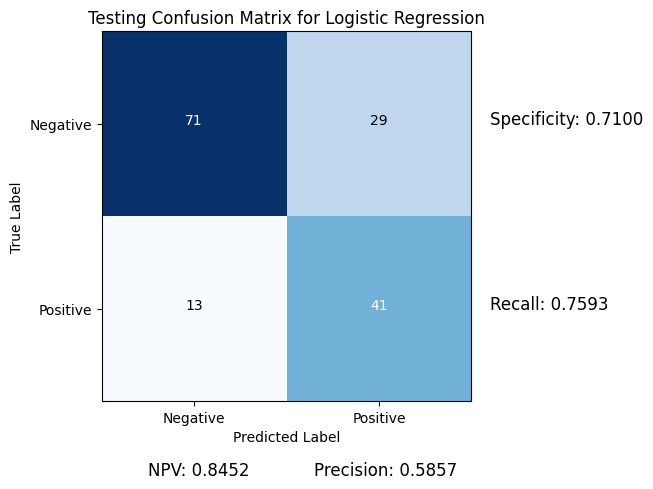

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred > best_threshold)

# Calculate precision, recall, NPV, specificity
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
npv = tn / (tn + fn)
specificity = tn / (tn + fp)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Testing Confusion Matrix for Logistic Regression')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Add precision, recall, NPV, specificity to plot
plt.text(0.65, 1.9, f"Precision: {precision:.4f}", color="black", fontsize=12)
plt.text(-0.25, 1.9, f"NPV: {npv:.4f}", color="black", fontsize=12)
plt.text(1.6, 1, f"Recall: {recall:.4f}", color="black", fontsize=12)
plt.text(1.6, 0, f"Specificity: {specificity:.4f}", color="black", fontsize=12)

plt.show()


## Visualize Logistic Curves

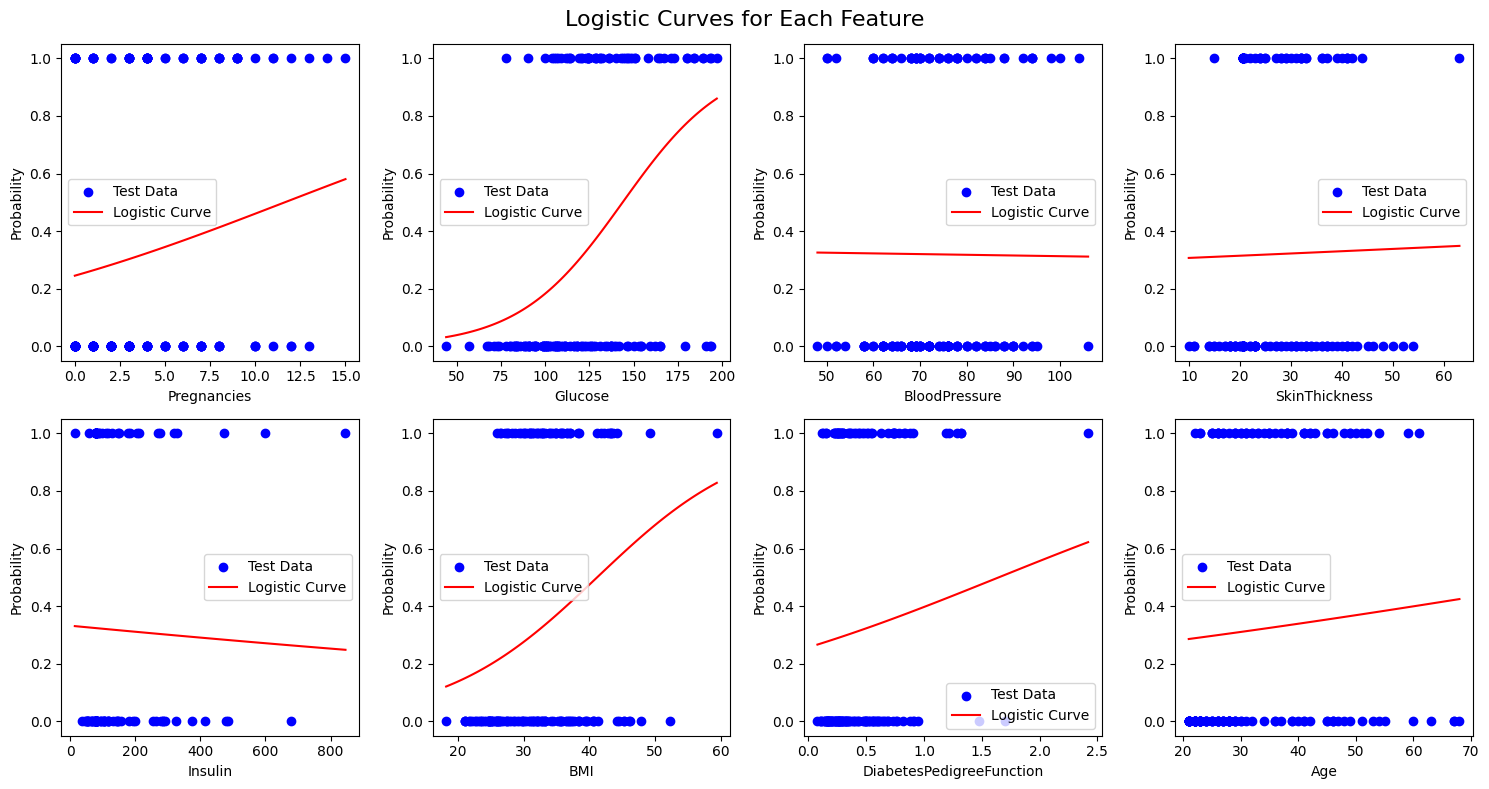

In [7]:
from scipy.special import expit

# Define the logistic function
def logistic(x, beta, intercept):
    return expit(beta * x + intercept)

# Scale back the features
X_scaled_back = scaler.inverse_transform(X_test)

# Plot the logistic curves for each feature
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
axs = axs.flatten()

for i, col in enumerate(X_cols):
    # Get the feature values
    x_scaled_back = X_scaled_back[:, i]
    x = X_test[:, i]
    y = y_test

    # Get the coefficients
    beta = logreg.coef_[0][i]
    intercept = logreg.intercept_[0]

    # Generate the x values for the logistic curve
    x_curve = np.linspace(np.min(x), np.max(x), 100)

    # Compute the y values for the logistic curve
    y_curve = logistic(x_curve, beta, intercept)

    # Scale back the x values
    x_curve_scaled_back = scaler.mean_[i] + x_curve * scaler.scale_[i]

    # Plot the logistic curve
    axs[i].scatter(x_scaled_back, y, color='b', label='Test Data')
    axs[i].plot(x_curve_scaled_back, y_curve, color='r', label='Logistic Curve')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Probability')
    axs[i].legend()

plt.suptitle('Logistic Curves for Each Feature', fontsize=16)
plt.tight_layout()
plt.show()


# Deep Learning

## Training with Cross Validation

In [8]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

# Hyperparameters
max_epochs = 1500
lr = 3e-4
weight_decay = 1e-5

# Convert training set to torch tensors
torch_train_X = torch.from_numpy(X_train).float()
torch_train_y = torch.from_numpy(y_train).float()

# Train and evaluate model on each fold
accs = []
aucs = []
train_losseses = []
train_accss = []
train_aucss = []
valid_losseses = []
valid_accss = []
valid_aucss = []
for train_index, valid_index in skf.split(torch_train_X, torch_train_y):
    fold_train_X, fold_valid_X = torch_train_X[train_index], torch_train_X[valid_index]
    fold_train_y, fold_valid_y = torch_train_y[train_index], torch_train_y[valid_index]

    model = torch.nn.Sequential(
        torch.nn.Linear(8, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 1),
        torch.nn.Sigmoid()
    )
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    best_auc = -1
    best_model = None

    train_losses = []
    train_accs = []
    train_aucs = []
    valid_losses = []
    valid_accs = []
    valid_aucs = []

    for epoch in range(max_epochs):
        # training
        model.train()
        optimizer.zero_grad()
        pred = model(fold_train_X).squeeze(1)
        loss = loss_fn(pred, fold_train_y)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        train_losses.append(loss.item())
        pred = pred.detach().numpy()
        acc = accuracy_score(fold_train_y, pred > 0.5)
        auc = roc_auc_score(fold_train_y, pred)
        train_accs.append(acc)
        train_aucs.append(auc)

        # validation
        model.eval()
        pred = model(fold_valid_X).squeeze(1)
        valid_losses.append(loss_fn(pred, fold_valid_y).item())
        pred = pred.detach().numpy()
        acc = accuracy_score(fold_valid_y, pred > 0.5)
        auc = roc_auc_score(fold_valid_y, pred)
        valid_accs.append(acc)
        valid_aucs.append(auc)

        if auc > best_auc:
            best_auc = auc
            best_model = model.state_dict()

    # logging
    train_losseses.append(train_losses)
    train_accss.append(train_accs)
    train_aucss.append(train_aucs)
    valid_losseses.append(valid_losses)
    valid_accss.append(valid_accs)
    valid_aucss.append(valid_aucs)

    # evaluate on best model
    model.load_state_dict(best_model)
    model.eval()
    pred = model(fold_valid_X).squeeze(1).detach().numpy()
    acc = accuracy_score(fold_valid_y, pred > 0.5)
    auc = roc_auc_score(fold_valid_y, pred)
    accs.append(acc)
    aucs.append(auc)

print(f"ACC: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


ACC: 0.7834 ± 0.0114
AUC: 0.8462 ± 0.0146


## Visualize Training Logs

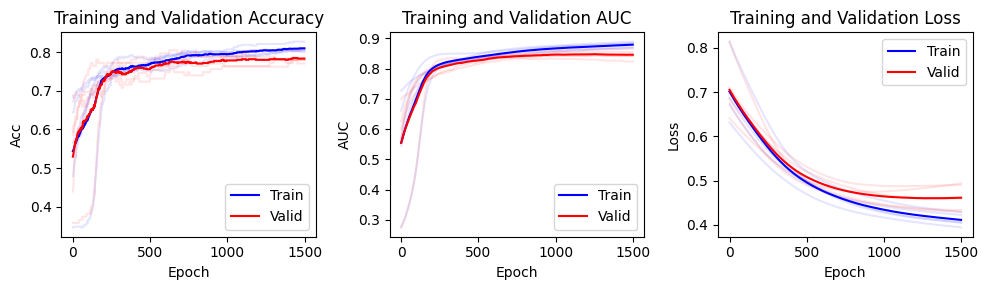

In [9]:

# Plot accuracy, AUC, and loss together
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot accuracy
average_train_accs = np.mean(train_accss, axis=0)
average_valid_accs = np.mean(valid_accss, axis=0)
for train_accs, valid_accs in zip(train_accss, valid_accss):
    axs[0].plot(train_accs, color="b", alpha=0.1)
    axs[0].plot(valid_accs, color="r", alpha=0.1)
axs[0].plot(average_train_accs, label="Train", color="b")
axs[0].plot(average_valid_accs, label="Valid", color="r")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Acc")
axs[0].set_title("Training and Validation Accuracy")
axs[0].legend()

# Plot AUC
average_train_aucs = np.mean(train_aucss, axis=0)
average_valid_aucs = np.mean(valid_aucss, axis=0)
for train_aucs, valid_aucs in zip(train_aucss, valid_aucss):
    axs[1].plot(train_aucs, color="b", alpha=0.1)
    axs[1].plot(valid_aucs, color="r", alpha=0.1)
axs[1].plot(average_train_aucs, label="Train", color="b")
axs[1].plot(average_valid_aucs, label="Valid", color="r")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("AUC")
axs[1].set_title("Training and Validation AUC")
axs[1].legend()

# Plot loss
average_train_losses = np.mean(train_losseses, axis=0)
average_valid_losses = np.mean(valid_losseses, axis=0)
for train_losses, valid_losses in zip(train_losseses, valid_losseses):
    axs[2].plot(train_losses, color="b", alpha=0.1)
    axs[2].plot(valid_losses, color="r", alpha=0.1)
axs[2].plot(average_train_losses, label="Train", color="b")
axs[2].plot(average_valid_losses, label="Valid", color="r")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training and Validation Loss")
axs[2].legend()

plt.tight_layout()
plt.show()


## Final Evaluation on Holdout Set

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(8, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

best_auc = -1
best_model = None

# Convert data to torch tensors
X_train_valid_torch = torch.from_numpy(X_train).float()
y_train_valid_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()

X_train_torch, X_valid_torch, y_train_torch, y_valid_torch = train_test_split(
    X_train_valid_torch, y_train_valid_torch, test_size=0.2, random_state=42, shuffle=True, stratify=y_train_valid_torch
)

for epoch in range(max_epochs):
    # training
    model.train()
    optimizer.zero_grad()
    pred = model(X_train_torch).squeeze(1)
    loss = loss_fn(pred, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    # validation
    model.eval()
    pred = model(X_valid_torch).squeeze(1).detach().numpy()
    auc = roc_auc_score(y_valid_torch, pred)

    if auc > best_auc:
        best_auc = auc
        best_model = model.state_dict()

# Calculate the predicted probabilities for the positive class
pred_prob = model(X_train_valid_torch).squeeze(1).detach().numpy()

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_train, pred_prob)

# Calculate the Youden index for each threshold
youden_index = tpr - fpr

# Find the threshold that maximizes the Youden index
best_threshold = thresholds[np.argmax(youden_index)]

print(f"Best threshold: {best_threshold:.4f}")

# evaluate
model.load_state_dict(best_model)
model.eval()
pred = model(X_test_torch).squeeze(1).detach().numpy()
acc = accuracy_score(y_test, pred > best_threshold)
auc = roc_auc_score(y_test, pred)

print(f"ACC on holdout set: {acc:.4f}")
print(f"AUC on holdout set: {auc:.4f}")


Best threshold: 0.3719
ACC on holdout set: 0.7597
AUC on holdout set: 0.8222


## Plot Confusion Matrix

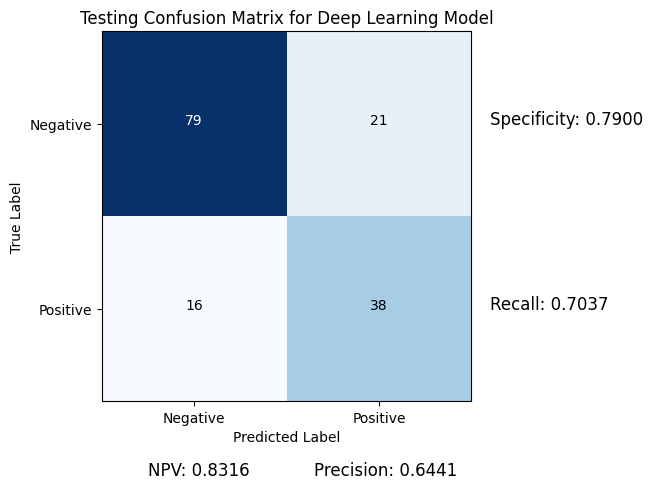

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred > best_threshold)

# Calculate precision, recall, NPV, specificity
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
npv = tn / (tn + fn)
specificity = tn / (tn + fp)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Testing Confusion Matrix for Deep Learning Model')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Add precision, recall, NPV, specificity to plot
plt.text(0.65, 1.9, f"Precision: {precision:.4f}", color="black", fontsize=12)
plt.text(-0.25, 1.9, f"NPV: {npv:.4f}", color="black", fontsize=12)
plt.text(1.6, 1, f"Recall: {recall:.4f}", color="black", fontsize=12)
plt.text(1.6, 0, f"Specificity: {specificity:.4f}", color="black", fontsize=12)

plt.show()
